# BCI Decoders
Use neural activity to predict arm kinematics on a single-trial basis

Single-neuron spikes were collected from the motor cortex of a monkey performing a reaching task, which required both straight and curved reaches (see [Churchland et al., 2012](https://www.nature.com/articles/nature11129) for full details)

We're going to train three decoders:
   1. Kalman filter (see [Wu et al., 2002](https://cs.brown.edu/people/mjblack/Papers/sab2002.pdf))
   2. Wiener filter (see [Carmena et al., 2003](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0000042))
   3. Feedforward neural network


#### import necessary modules

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

import models
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### load and unpack the data
The data have been arranged into lists, where each element corresponds to neural or kinematic activity from a single trial. Data are taken from a -250 - 500 ms window around movement onset.

   spikes: a list of spike times for every trial. This dataset contains activity from 182 simultaneously recorded neurons

   position: a list of hand position vectors. Each entry in 'position' is a T x 2 array (x and y hand position)

   velocity: same as 'position', but for hand velocity (calculated/filtered offline)

In [4]:
# load the data
fName = 'data/MC_reaching.pkl'
with open(fName,'rb') as file:
    data = pickle.load(file)

# unpack everything
spikes   = data['spikes']
position = data['position']
velocity = data['velocity']

# pull out some useful variables
trialDuration = position[0].shape[0]*0.001
numTrials = len(position)

# define a sampling time (in seconds)
Ts = 0.001

#### define a bin width (in seconds) to use for our decoders

In [15]:
binWidth = 0.03

# place these parameters in a dictionary to pass to the decode objects
Hyperparameters = {'bin_width': binWidth, 'Ts': Ts}

#### number of trials to use for training each model

In [16]:
numTrainingTrials = 2000

#### train and test the kalman filter

In [17]:
# train
kalman = models.Kalman(Hyperparameters)
kalman.fit(z=spikes[:numTrainingTrials], position=position[:numTrainingTrials], velocity=velocity[:numTrainingTrials])

# test
X_hat_kalman, R2_kalman = kalman.predict(z=spikes[numTrainingTrials:], position=position[numTrainingTrials:], velocity=velocity[numTrainingTrials:])

#### Wiener filter

In [18]:
# add a few hyperparameters

# number of lagging bins to use when predicting kinematics
Hyperparameters['num_lagging_bins'] = 5

# magnitude of the ridge penalty (necessary to prevent overfitting to training data)
Hyperparameters['ridge_lambda'] = 1000

# train and test model
wiener = models.Wiener(Hyperparameters)
wiener.fit(z=spikes[:numTrainingTrials], kinematics=velocity[:numTrainingTrials])
X_hat_wiener, R2_wiener = wiener.predict(z=spikes[numTrainingTrials:], kinematics=velocity[numTrainingTrials:])


#### Feedforward network

In [19]:
# add a few more hyperparameters

# number of hidden layers
Hyperparameters['num_hidden_layers'] = 10

# units per layer
Hyperparameters['num_units_per_layer'] = 300

# define the fitting parameters (batch and epoch sizes, and drop-out fraction)
fit_parameters = {'batch_size': 20, 'num_epochs': 200, 'dropout_p': 0.2}

# train and test
ff_net = models.FF_network(Hyperparameters)
ff_net.fit(z=spikes[:numTrainingTrials], kinematics=velocity[:numTrainingTrials], fit_parameters = fit_parameters)
X_hat_ff, R2_ff = ff_net.predict(z=spikes[numTrainingTrials:], kinematics=velocity[numTrainingTrials:])

#### plot performance on held-out data

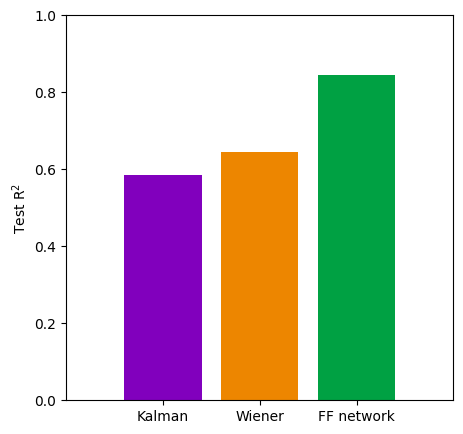

In [20]:
# define some nice plotting colors (kalman: purple; wiener: orange; feedforward network: green)
colors = ['#8100bd', '#ed8600', '#00a143']
modelLabels = ['Kalman', 'Wiener', 'FF network']

# plot
r2 = [R2_kalman, R2_wiener, R2_ff]
plt.figure(figsize=(5,5));
for ii in range(3):
    plt.bar(ii, np.mean(r2[ii]), color=colors[ii] )

# clean up
plt.xlim([-1,3]);
plt.ylim([0,1]);
plt.ylabel('Test R$^2$');
plt.xticks(ticks=np.arange(3), labels=modelLabels);


#### plot actual and predicted velocity for a single trial

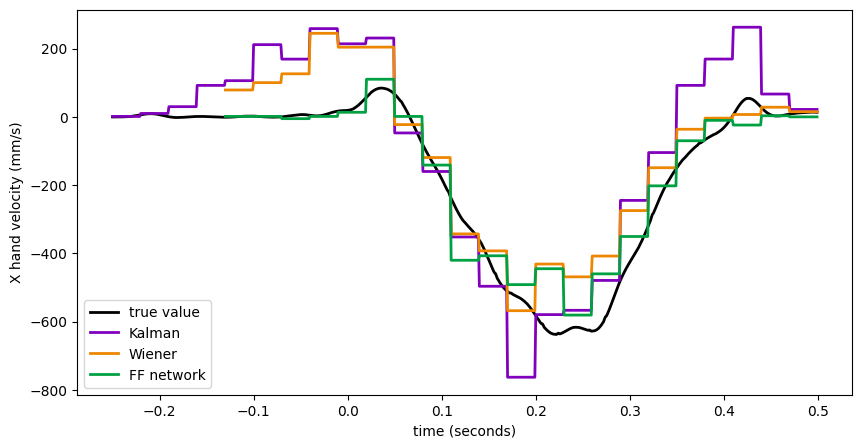

In [25]:
# choose a random test trial
trialIdx = np.random.randint(0, len(spikes[numTrainingTrials:]) )

# pull out the true Hand X velocity for this trial
testVel = velocity[numTrainingTrials:]
velTrue = testVel[trialIdx][:,0]

# define a time vector (0 is movement onset)
time = np.arange(-0.25, 0.5, Ts)

# pull out the predicted kinematics for this trial
predVel = [X_hat_kalman[trialIdx][2,:], X_hat_wiener[trialIdx][:,0], X_hat_ff[trialIdx][:,0]]

# upsample the predicted kinematics (using a zero-order hold) to get the prediction on the same sample rate as the original data
predVel_us = [utils.zero_order_hold_upsample(predVel[ii],int(binWidth/Ts) ) for ii in range(3)]

# plot
plt.figure(figsize=(10,5));

# plot the true value
plt.plot(time, velTrue, color='k', label='true value', lw=2);

# plot the predictions
for ii in range(3):

    # predictions will be different lengths, depending on the number of lagging bins we included
    startIdx = time.shape[0] - predVel_us[ii].shape[0]
    plt.plot(time[int(startIdx):], predVel_us[ii], color=colors[ii], label=modelLabels[ii], lw=2)

# clean up
plt.xlabel('time (seconds)')
plt.ylabel('X hand velocity (mm/s)');
plt.legend();

